High Density Areas of Urban Development	cit.014	http://data.jrc.ec.europa.eu/dataset/jrc-ghsl-ghs_smod_pop_globe_r2016a

In [3]:
import numpy as np
import pandas as pd
import rasterio as rio

import boto3
import requests as req

from matplotlib import pyplot as plt
%matplotlib inline
import os
import sys
import threading

Establish s3 location

In [6]:
# Investigate what the data in these rasters means, and whether we can 
# Display high and low density clusters separately as is
s3_bucket = "wri-public-data"
s3_folder = "resourcewatch/raster/cit_014_areas_of_urban_development/"

s3_files = ["cit_014_areas_of_urban_development_1975.tif",
            "cit_014_areas_of_urban_development_1990.tif",
            "cit_014_areas_of_urban_development_2000.tif",
            "cit_014_areas_of_urban_development_2015.tif",
            "cit_014_areas_of_urban_development_2015_HDC.tif",
            "cit_014_areas_of_urban_development_2015_LDC.tif"]

s3_file_merge = "cit_014_areas_of_urban_development_merge.tif"

s3_key_origs = []
s3_key_edits = []

for file in s3_files:
    orig = s3_folder + file
    s3_key_origs.append(orig)
    s3_key_edits.append(orig[0:-4] + "_edit.tif")
    
s3_key_merge = s3_folder + s3_file_merge


s3_upload = boto3.client("s3")
s3_download = boto3.resource("s3")

class ProgressPercentage(object):
        def __init__(self, filename):
            self._filename = filename
            self._size = float(os.path.getsize(filename))
            self._seen_so_far = 0
            self._lock = threading.Lock()

        def __call__(self, bytes_amount):
            # To simplify we'll assume this is hooked up
            # to a single filename.
            with self._lock:
                self._seen_so_far += bytes_amount
                percentage = (self._seen_so_far / self._size) * 100
                sys.stdout.write(
                    "\r%s  %s / %s  (%.2f%%)" % (
                        self._filename, self._seen_so_far, self._size,
                        percentage))
                sys.stdout.flush()

Local files

In [18]:
local_folder = "/Users/nathansuberi/Desktop/RW_Data/"
local_orig_keys = []
local_edit_keys = []

for file in s3_files:
    local_orig_keys.append(local_folder + file)
    local_edit_keys.append(local_folder + file[0:-4] + "_edit.tif")

local_merge_key = local_folder + s3_file_merge

In [7]:
local_edit_keys

['/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_1975_edit.tif',
 '/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_1990_edit.tif',
 '/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_2000_edit.tif',
 '/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_2015_edit.tif',
 '/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_2015_HDC_edit.tif',
 '/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_2015_LDC_edit.tif']

In [9]:
# Defined above:
# s3_bucket
# s3_key_orig
# s3_key_edit
# staging_key_orig
# staging_key_edit
for ix, file in enumerate(s3_key_origs):
    s3_download.meta.client.download_file(s3_bucket, file, local_orig_keys[ix])

Process files

In [11]:
for file in local_orig_keys:
    with rio.open(file) as src:
        print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 35497, 'height': 15236, 'count': 1, 'crs': CRS({'proj': 'moll', 'lon_0': 0, 'x_0': 0, 'y_0': 0, 'ellps': 'WGS84', 'units': 'm', 'no_defs': True}), 'transform': (-17619594.54744353, 1000.0, 0.0, 8751029.46186849, 0.0, -1000.0), 'affine': Affine(1000.0, 0.0, -17619594.54744353,
       0.0, -1000.0, 8751029.46186849), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 35497, 'height': 15236, 'count': 1, 'crs': CRS({'proj': 'moll', 'lon_0': 0, 'x_0': 0, 'y_0': 0, 'ellps': 'WGS84', 'units': 'm', 'no_defs': True}), 'transform': (-17619594.54744353, 1000.0, 0.0, 8751029.46186849, 0.0, -1000.0), 'affine': Affine(1000.0, 0.0, -17619594.54744353,
       0.0, -1000.0, 8751029.46186849), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None

Upload edited files to S3

In [16]:
def reproject_file(orig_name, edit_name):
    with rio.open(orig_name, 'r') as src:
        # This assumes data is readable by rasterio
        # May need to open instead with netcdf4.Dataset, for example
        
        srcprofile = src.profile
        rows = srcprofile["height"]
        columns = srcprofile["width"]

        print(rows)
        print(columns)

        # Latitude bounds
        south_lat = -90
        north_lat = 90

        # Longitude bounds
        west_lon = -180
        east_lon = 180

        transform = rio.transform.from_bounds(west_lon, south_lat, east_lon, north_lat, columns, rows)

        # Profile

        no_data_val = srcprofile["nodata"]
        target_projection = 'EPSG:4326'
        target_data_type = np.float64

        profile = {
            'driver':'GTiff', 
            'height':rows, 
            'width':columns, 
            'count':1, 
            'dtype':target_data_type, 
            'crs':target_projection, 
            'transform':transform, 
            'compress':'lzw', 
            'nodata': no_data_val
        }

        windows = src.block_windows()
        with rio.open(edit_name, "w", **profile) as dst:
            for ix, window in windows:
                data = src.read(1, window=window)
                dst.write(data.astype(profile["dtype"]),1, window=window)

In [13]:
s3_key_edits

['resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1975_edit.tif',
 'resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1990_edit.tif',
 'resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_2000_edit.tif',
 'resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_2015_edit.tif',
 'resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_2015_HDC_edit.tif',
 'resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_2015_LDC_edit.tif']

In [31]:
for i in range(0,6):
    orig_key = local_orig_keys[i]
    edit_key = local_edit_keys[i]
    reproject_file(orig_key, edit_key)
    s3_upload.upload_file(edit_key, s3_bucket, s3_key_edits[i],
               Callback=ProgressPercentage(edit_key))

15236
35497


KeyboardInterrupt: 

Merge files and upload to s3

In [24]:
with rio.open(local_edit_keys[0], 'r') as src:
    profile = src.profile
    
profile.update(count=len(local_edit_keys))

with rio.open(local_merge_key, 'w', **profile) as dst:
    for idx, file in enumerate(local_edit_keys):
        print(idx)
        with rio.open(file) as src:
            band = idx+1
            windows = src.block_windows()
            for win_id, window in windows:
                src_data = src.read(1, window=window)
                dst.write_band(band, src_data, window=window)

s3_upload.upload_file(local_merge_key, s3_bucket, s3_key_merge,
           Callback=ProgressPercentage(local_merge_key))

/Users/nathansuberi/Desktop/RW_Data/cit_014_areas_of_urban_development_merge.tif  207084647 / 207084647.0  (100.00%)

In [ ]:
s3_upload.upload_file(local_merge_key, s3_bucket, s3_key_merge,
           Callback=ProgressPercentage(local_merge_key))

Upload to GEE

In [25]:
os.environ["s3_key"] = "s3://wri-public-data/" + s3_key_merge
os.environ["gs_key"] = "gs://resource-watch-public/" + s3_key_merge

!gsutil cp $s3_key $gs_key

Non-MD5 etag ("598d2e1c795c5c786ea954d8a9f83b05-25") present for key <Key: wri-public-data,resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_merge.tif>, data integrity checks are not possible.
Copying s3://wri-public-data/resourcewatch/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_merge.tif [Content-Type=binary/octet-stream]...
/ [1 files][197.5 MiB/197.5 MiB]    7.7 MiB/s                                   
Operation completed over 1 objects/197.5 MiB.                                    


In [33]:
for file in s3_key_origs:
    os.environ["s3_key"] = "s3://wri-public-data/" + file
    os.environ["gs_key"] = "gs://resource-watch-public/" + file

    !gsutil cp $s3_key $gs_key

Copying s3://wri-public-data/resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1975.tif [Content-Type=binary/octet-stream]...
\ [1 files][  6.5 MiB/  6.5 MiB]                                                
Operation completed over 1 objects/6.5 MiB.                                      
Copying s3://wri-public-data/resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1990.tif [Content-Type=binary/octet-stream]...
- [1 files][  7.2 MiB/  7.2 MiB]                                                
Operation completed over 1 objects/7.2 MiB.                                      
Copying s3://wri-public-data/resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_2000.tif [Content-Type=binary/octet-stream]...
\ [1 files][  7.6 MiB/  7.6 MiB]                                                
Operation completed over 1 objects/7.6 MiB.                                      
Copying s3

In [34]:
for file in s3_key_edits:
    os.environ["s3_key"] = "s3://wri-public-data/" + file
    os.environ["gs_key"] = "gs://resource-watch-public/" + file

    !gsutil cp $s3_key $gs_key

Non-MD5 etag ("040c349e17c8ff62788a6a72b36eb9d5-5") present for key <Key: wri-public-data,resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1975_edit.tif>, data integrity checks are not possible.
Copying s3://wri-public-data/resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1975_edit.tif [Content-Type=binary/octet-stream]...
/ [1 files][ 39.0 MiB/ 39.0 MiB]                                                
Operation completed over 1 objects/39.0 MiB.                                     
Non-MD5 etag ("4b20d784f324e4ef9d3030848695add0-5") present for key <Key: wri-public-data,resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1990_edit.tif>, data integrity checks are not possible.
Copying s3://wri-public-data/resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_areas_of_urban_development_1990_edit.tif [Content-Type=binary/octet-stream]...
- [1 files][ 38.3 M

Create assets

In [26]:
os.environ["gs_key"] = "gs://resource-watch-public/" + s3_key_merge
os.environ["asset_id"] = "users/resourcewatch/cit_014_areas_of_urban_development_merged"

!earthengine upload image --asset_id=$asset_id $gs_key

Started upload task with ID: SSYOUDLMBOS73WFM26N2DDC4


In [37]:
s3_files[0][0:-4]

'cit_014_areas_of_urban_development_1975'

In [39]:
for ix, file in enumerate(s3_files):
    os.environ["gs_key"] = "gs://resource-watch-public/" + s3_key_origs[ix]
    os.environ["asset_id"] = "users/resourcewatch/" + file[:-4]

    !earthengine upload image --asset_id=$asset_id $gs_key

Started upload task with ID: 4VI4IU75JFFU2XCRMUM7DF5O
Started upload task with ID: PIKH7LIWVUOOHIVQJ3TGBQF5
Started upload task with ID: OGEXAZP2K3AIA35Q2BAOQYGE
Started upload task with ID: YSDWWF4UZPCLMLQJKKGHVKV3
Started upload task with ID: FS6SYSEDUGZ7OOS7H3UZADZF
Started upload task with ID: VA2HQVFNPXMFWYAKZR2OENPH


In [40]:
for ix, file in enumerate(s3_files):
    os.environ["gs_key"] = "gs://resource-watch-public/" + s3_key_edits[ix]
    os.environ["asset_id"] = "users/resourcewatch/" + file[:-4] + "_edit"

    !earthengine upload image --asset_id=$asset_id $gs_key

Started upload task with ID: MEJI6LPVPNSSUABNENFI5FAU
Started upload task with ID: UZHUNG4JJK5P4MKFB63M3WML
Started upload task with ID: 6NGE7NTTIV7MFMH5TK5Q6POP
Started upload task with ID: YDQYDY2RIX3YMSMZFO5ULFG5
Started upload task with ID: DQ6GPR6A5TAVANFVHFWUDSUE
Started upload task with ID: M25P7LBDU7H6MVWA333FZ4DR


In [ ]:
!earthengine acl set public $asset_id

In [ ]:
# os.environ["band_names"] = str(band_names)

# !earthengine asset set -p '(string)band_names='"$band_names" $asset_id

In [4]:
os.chdir("/Users/nathansuberi/Desktop/RW_Data/")

orig_files = [
    "GHS_BUILT_LDS1975_GLOBE_R2016A_54009_250_v1_0_rioedit.tif",
    "GHS_BUILT_LDS1990_GLOBE_R2016A_54009_250_v1_0_rioedit.tif",
    "GHS_BUILT_LDS2000_GLOBE_R2016A_54009_250_v1_0_rioedit.tif",
    "GHS_BUILT_LDS2014_GLOBE_R2016A_54009_250_v1_0_rioedit.tif"
]

merge_file = "GHS_BUILT_LDS_GLOBE_R2016A_54009_250_v1_0_merge.tif"

s3_key_builtup_merge = "resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_built_up_areas_merge.tif"

with rio.open(orig_files[0], "r") as src:
    profile = src.profile
    print(profile)
    
band_names = [1975, 1990, 2000, 2014]
profile.update(count=4, bands=band_names)

import time

with rio.open(merge_file, "w", **profile) as dst:
    for ix, file in enumerate(orig_files):
        with rio.open(file, 'r') as src:
            print(file)
            print(time.localtime(time.time()))
            windows = src.block_windows()
            for win_ix, window in windows:
                data = src.read(indexes=1, window=window)
                np.putmask(data, data==src.profile["nodata"], 0)
                dst.write(data, indexes=ix+1, window=window)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 144060, 'height': 55869, 'count': 1, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0024989486053415473, 0.0, -179.99999911850753,
       0.0, -0.002498965952043977, 83.63080127242071), 'blockxsize': 512, 'blockysize': 512, 'compress': 'lzw', 'interleave': 'band', 'tiled': True}
GHS_BUILT_LDS1975_GLOBE_R2016A_54009_250_v1_0_rioedit.tif
time.struct_time(tm_year=2017, tm_mon=10, tm_mday=6, tm_hour=14, tm_min=12, tm_sec=57, tm_wday=4, tm_yday=279, tm_isdst=1)
GHS_BUILT_LDS1990_GLOBE_R2016A_54009_250_v1_0_rioedit.tif
time.struct_time(tm_year=2017, tm_mon=10, tm_mday=6, tm_hour=14, tm_min=21, tm_sec=55, tm_wday=4, tm_yday=279, tm_isdst=1)
GHS_BUILT_LDS2000_GLOBE_R2016A_54009_250_v1_0_rioedit.tif
time.struct_time(tm_year=2017, tm_mon=10, tm_mday=6, tm_hour=14, tm_min=31, tm_sec=50, tm_wday=4, tm_yday=279, tm_isdst=1)
GHS_BUILT_LDS2014_GLOBE_R2016A_54009_250_v1_0_rioedit.tif
time.struct_time(tm_year=2017, tm_m

In [7]:
s3_key_builtup_merge_nodata_set_to_zero = "resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_built_up_areas_merge_nodata_set_to_zero.tif"

s3_upload.upload_file(merge_file, s3_bucket, s3_key_builtup_merge_nodata_set_to_zero,
           Callback=ProgressPercentage(merge_file))

GHS_BUILT_LDS_GLOBE_R2016A_54009_250_v1_0_merge.tif  948470244 / 948470244.0  (100.00%)

In [29]:
s3_key_builtup_merge

'resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_built_up_areas_merge.tif'

In [8]:
os.environ["s3_key"] = "s3://" +s3_bucket+"/"+ s3_key_builtup_merge_nodata_set_to_zero
os.environ["gs_key"] = "gs://resource-watch-public/" + s3_key_builtup_merge_nodata_set_to_zero
os.environ["asset_id"] = "users/resourcewatch/cit_014_built_up_areas_nodata_set_to_zero"

!gsutil cp $s3_key $gs_key



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Non-MD5 etag ("d22f4b813d4210160941440de0d3b55b-114") present for key <Key: wri-public-data,resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_built_up_areas_merge_nodata_set_to_zero.tif>, data integrity checks are not possible.
Copying s3://wri-public-data/resourcewatch/raster/cit_014_areas_of_urban_development/cit_014_built_up_areas_merge_nodata_set_to_zero.tif [Content-Type=binary/octet-stream]...
\ [1 files][904.5 MiB/904.5 MiB]   10.8 MiB/s                                   
Operation completed over 1 objects/904.5 MiB.                                    


In [9]:
!earthengine upload image --asset_id=$asset_id $gs_key

Started upload task with ID: 4VBSBIT62BXDT6JYVCIDLFHK


In [12]:
!earthengine task info 4VBSBIT62BXDT6JYVCIDLFHK

4VBSBIT62BXDT6JYVCIDLFHK:
  State: RUNNING
  Type: Upload
  Description: Asset ingestion: users/resourcewatch/cit_014_built_up_areas_nodata_set_to_zero
  Created: 2017-10-06 15:08:53.803000
  Started: 2017-10-06 15:08:55.111000
  Updated: 2017-10-06 15:13:55.245000


In [38]:
band_names = [1975, 1990, 2000, 2014]
os.environ["bandnames"] = str(band_names)
!earthengine asset set -p "(string)bandname=$bandnames" users/resourcewatch/cit_014_built_up_areas_nodata_set_to_zero

In [41]:
with rio.open(merge_file, "r") as src:
    print(src.profile)
    window = ((10000, 100000), (10000, 60000))
    data = src.read(indexes=4, window=window)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 144060, 'height': 55869, 'count': 4, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0024989486053415473, 0.0, -179.99999911850753,
       0.0, -0.002498965952043977, 83.63080127242071), 'bands': '[1975, 1990, 2000, 2014]', 'blockxsize': 512, 'blockysize': 512, 'compress': 'lzw', 'interleave': 'band', 'tiled': True}


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.402823e+38, 'width': 144060, 'height': 55869, 'count': 4, 'crs': CRS({'init': 'epsg:4326'}), 'transform': Affine(0.0024989486053415473, 0.0, -179.99999911850753,
       0.0, -0.002498965952043977, 83.63080127242071), 'bands': '[1975, 1990, 2000, 2014]', 'blockxsize': 512, 'blockysize': 512, 'compress': 'lzw', 'interleave': 'band', 'tiled': True}


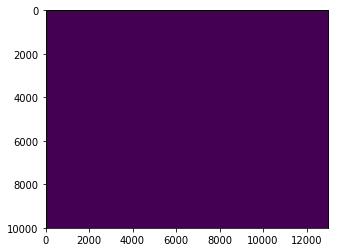

In [1]:
import rasterio as rio
from matplotlib import pyplot
%matplotlib inline
import os
merge_file = "GHS_BUILT_LDS_GLOBE_R2016A_54009_250_v1_0_merge.tif"
os.chdir("/Users/nathansuberi/Desktop/RW_Data/")

with rio.open(merge_file, "r") as src:
    print(src.profile)
    window = ((10000, 20000), (2000, 15000))
    data = src.read(indexes=4, window=window)
    pyplot.imshow(data)